In [25]:
print("hello world")

hello world


In [26]:
!python3 -m pip install networkx matplotlib


In [27]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import matplotlib.animation as animation

# Create a mesh network (4x4 example)
size_x = 5
size_y = 7
G = nx.grid_2d_graph(size_x, size_y)

positions = {(x, y): (x, -y) for x, y in G.nodes()}  # for plotting


In [28]:
# === XY Routing Function ===
def xy_routing(src, dst):
    path = []
    x1, y1 = src
    x2, y2 = dst

    x_step = 1 if x2 > x1 else -1
    for x in range(x1, x2, x_step):
        path.append((x, y1))

    y_step = 1 if y2 > y1 else -1
    for y in range(y1, y2, y_step):
        path.append((x2, y))

    path.append(dst)
    return path

In [29]:
# === Simulate Traffic ===
num_packets = 10
packet_info = []  # [(src, dst, path, latency)]

In [30]:
for _ in range(num_packets):
    src = (random.randint(0, size_x - 1), random.randint(0, size_y - 1))
    dst = (random.randint(0, size_x - 1), random.randint(0, size_y - 1))
    while dst == src:
        dst = (random.randint(0, size_x - 1), random.randint(0, size_y - 1))
    
    path = xy_routing(src, dst)
    latency = len(path) - 1  # hop count
    packet_info.append((src, dst, path, latency))

# === Output Result ===
for i, (src, dst, path, latency) in enumerate(packet_info):
    print(f"Packet {i+1}: {src} -> {dst} | Path: {path} | Latency: {latency}")

Packet 1: (3, 0) -> (0, 0) | Path: [(3, 0), (2, 0), (1, 0), (0, 0)] | Latency: 3
Packet 2: (3, 0) -> (1, 2) | Path: [(3, 0), (2, 0), (1, 0), (1, 1), (1, 2)] | Latency: 4
Packet 3: (3, 5) -> (4, 2) | Path: [(3, 5), (4, 5), (4, 4), (4, 3), (4, 2)] | Latency: 4
Packet 4: (4, 3) -> (2, 2) | Path: [(4, 3), (3, 3), (2, 3), (2, 2)] | Latency: 3
Packet 5: (0, 6) -> (0, 5) | Path: [(0, 6), (0, 5)] | Latency: 1
Packet 6: (3, 2) -> (1, 3) | Path: [(3, 2), (2, 2), (1, 2), (1, 3)] | Latency: 3
Packet 7: (4, 5) -> (3, 3) | Path: [(4, 5), (3, 5), (3, 4), (3, 3)] | Latency: 3
Packet 8: (4, 4) -> (2, 0) | Path: [(4, 4), (3, 4), (2, 4), (2, 3), (2, 2), (2, 1), (2, 0)] | Latency: 6
Packet 9: (1, 6) -> (1, 2) | Path: [(1, 6), (1, 5), (1, 4), (1, 3), (1, 2)] | Latency: 4
Packet 10: (2, 1) -> (0, 4) | Path: [(2, 1), (1, 1), (0, 1), (0, 2), (0, 3), (0, 4)] | Latency: 5


In [31]:
#deadlock set 
deadlock_paths = [
    ((1, 1), (2, 1), [(1, 1), (2, 1)], 1),  # P1
    ((2, 1), (2, 2), [(2, 1), (2, 2)], 1),  # P2
    ((2, 2), (1, 2), [(2, 2), (1, 2)], 1),  # P3
    ((1, 2), (1, 1), [(1, 2), (1, 1)], 1),  # P4
]

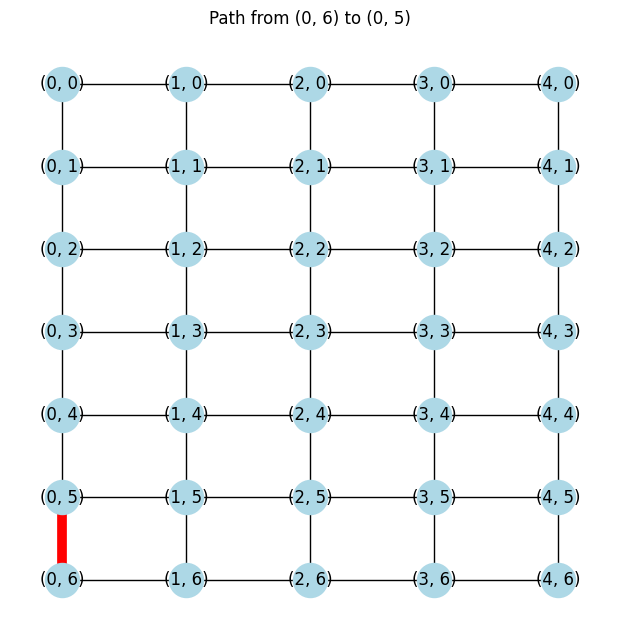

In [32]:

#demonstrate one path
def draw_packet_path(G, positions, path, title="Packet Path", color="red"):
    """
    Visualizes a path through a 2D mesh network.
    
    Parameters:
    - G: The NetworkX graph (e.g., grid_2d_graph)
    - positions: Node positions for plotting
    - path: List of node tuples representing the path
    - title: Title for the plot
    - color: Edge color for the path
    """
    plt.figure(figsize=(6, 6))
    nx.draw(G, pos=positions, with_labels=True, node_color="lightblue", node_size=600)
    
    path_edges = list(zip(path[:-1], path[1:]))
    nx.draw_networkx_edges(G, pos=positions, edgelist=path_edges, edge_color=color, width=7)
    
    plt.title(title)
    plt.show()



src, dst, path, _ = packet_info[4]  # or any packet
draw_packet_path(G, positions, path, title=f"Path from {src} to {dst}")

/tmp/ipykernel_17302/64979944.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors


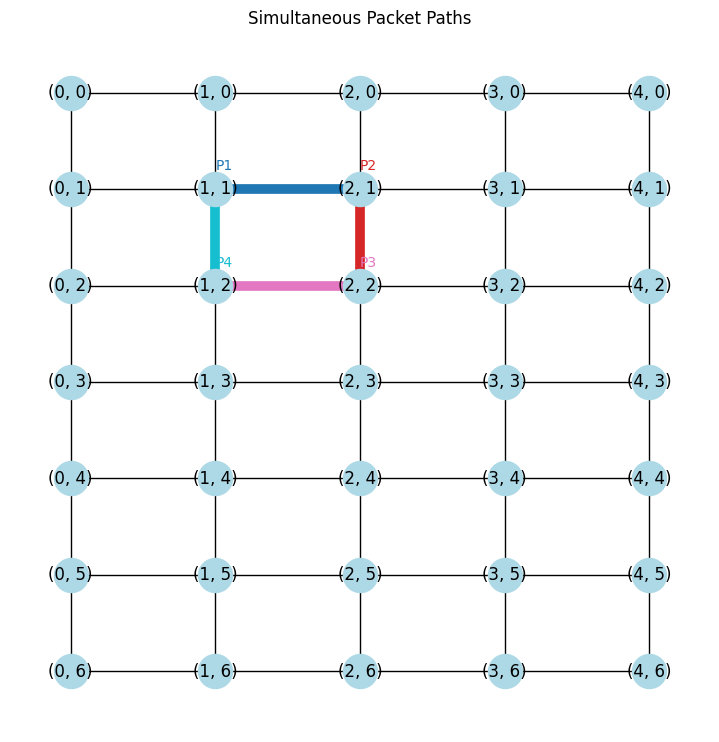

In [33]:
#demonstrate multiple paths
def draw_multiple_paths(G, positions, packet_paths, title="Simultaneous Packet Paths"):
    """
    Draws multiple packet paths on the same network graph.

    Parameters:
    - G: The networkx graph (e.g., 4x4 mesh)
    - positions: Dict of node positions for plotting
    - packet_paths: List of paths (each path is a list of node tuples)
    - title: Title for the plot
    """
    plt.figure(figsize=(7, 7))
    nx.draw(G, pos=positions, with_labels=True, node_color="lightblue", node_size=600)

    # Generate unique colors for each packet
    colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors

    for i, path in enumerate(packet_paths):
        edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(G, pos=positions, edgelist=edges, edge_color=[colors(i)], width=7, alpha=1)
        # label packets
        plt.text(path[0][0], -path[0][1] + 0.2, f'P{i+1}', fontsize=10, color=colors(i))

    plt.title(title)
    plt.show()

packet_paths = [p[2] for p in deadlock_paths]  # extract paths from packet_info
draw_multiple_paths(G, positions, packet_paths)

/tmp/ipykernel_17302/2183494773.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors


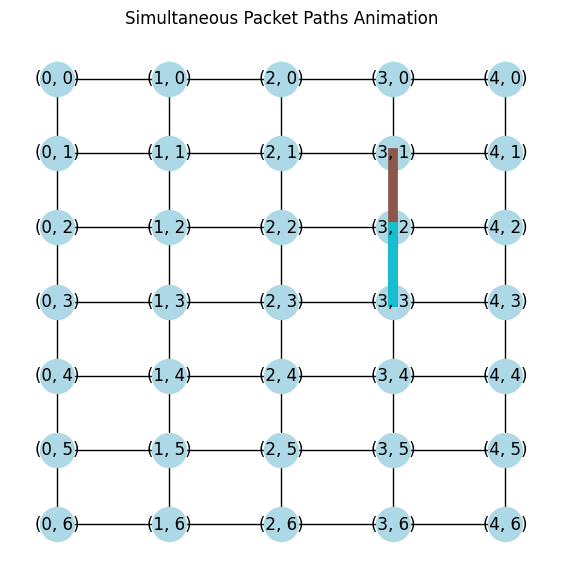

In [34]:


def animate_packet_paths(G, positions, packet_paths, title="Simultaneous Packet Paths Animation", interval=500):
    """
    Animates the movement of multiple packet paths on the same network graph.

    Parameters:
    - G: The NetworkX graph (e.g., grid_2d_graph)
    - positions: Dict of node positions for plotting
    - packet_paths: List of paths (each path is a list of node tuples)
    - title: Title for the plot
    - interval: Delay between each packet movement step (ms)
    """
    fig, ax = plt.subplots(figsize=(7, 7))

    # Generate unique colors for each packet
    colors = cm.get_cmap('tab10', len(packet_paths))  # tab10 = 10 distinct colors

    # Initial drawing of the graph
    nx.draw(G, pos=positions, with_labels=True, node_color="lightblue", node_size=600, ax=ax)
    
    # Prepare a list of line objects (for each packet)
    lines = []
    for i in range(len(packet_paths)):
        line, = ax.plot([], [], lw=7, color=colors(i))
        lines.append(line)
    
    # Function to initialize the animation (optional)
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    # Update function for each frame
    def update(frame):
        for i, path in enumerate(packet_paths):
            if frame < len(path) - 1:
                # Extract the start and end points of the current segment
                x_values = [path[frame][0], path[frame + 1][0]]
                y_values = [-path[frame][1], -path[frame + 1][1]]

                # Update the packet line with new coordinates
                lines[i].set_data(x_values, y_values)
        
        return lines

    # Set up the animation
    ani = animation.FuncAnimation(fig, update, frames=max(len(p) for p in packet_paths), 
                                  init_func=init, blit=True, interval=interval)
    ani.save("packets.mp4", writer='ffmpeg')

    plt.title(title)
    plt.show()

# Example usage:
# Simulate some packet paths
packet_paths = [xy_routing((0, 0), (3, 3)), xy_routing((0, 1), (3, 2)), xy_routing((1, 1), (3, 3))]
animate_packet_paths(G, positions, packet_paths, interval=500)


In [35]:
# add a section where if there if 2 lines meet at a node one has to wait for the other 
# add a section where if one line is waiting then the node of intersections turns red 
# visualise dead lock using the lines 